<a href="https://colab.research.google.com/github/2k33cse992574/A-ML-prep/blob/main/LogisticRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-293460510.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce'); df['TotalCharges'].fillna(0, inplace=True)
/tmp/ipython-input-293460510.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

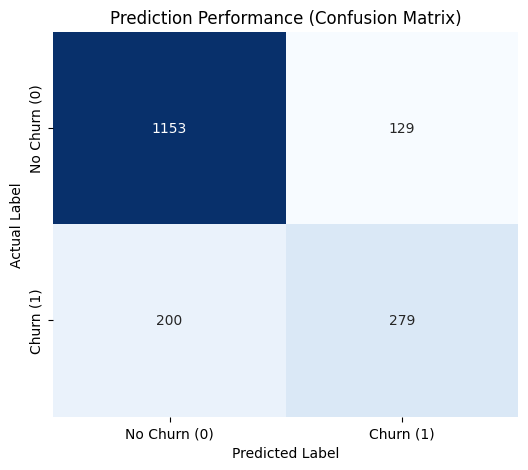

/tmp/ipython-input-293460510.py:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Odds_Ratio', y='Feature', data=top_features, palette='viridis')


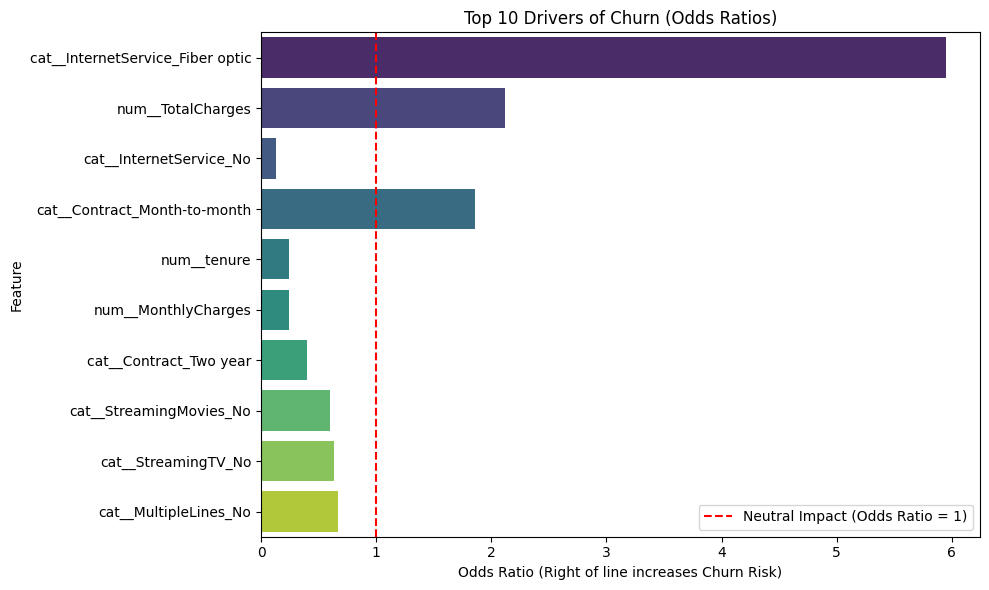


--- Final Model Metrics for LinkedIn ---
Best CV ROC AUC: 0.8411

Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.85      0.90      0.88      1282
           1       0.68      0.58      0.63       479

    accuracy                           0.81      1761
   macro avg       0.77      0.74      0.75      1761
weighted avg       0.81      0.81      0.81      1761



In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"
df = pd.read_csv(url)

df.drop('customerID', axis=1, inplace=True)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce'); df['TotalCharges'].fillna(0, inplace=True)
df['Churn'].replace({'Yes': 1, 'No': 0}, inplace=True)

internet_service_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                         'TechSupport', 'StreamingTV', 'StreamingMovies']
for col in internet_service_cols:
    df[col].replace('No internet service', 'No', inplace=True)

df['MultipleLines'].replace('No phone service', 'No', inplace=True)
df['gender'].replace({'Female': 0, 'Male': 1}, inplace=True)


Y=df['Churn']
X=df.drop('Churn',axis=1)

X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.25,random_state=42)

numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges','gender']

categorical_features = X.select_dtypes(include=['object']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'
)



pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42))
])


parameter = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': [0.1, 1.0, 10.0],
    'classifier__solver': ['liblinear'],
    'classifier__max_iter': [300],
    'classifier__class_weight': ['balanced', None]
}


classifier_regressor = GridSearchCV(
    pipeline,
    param_grid=parameter,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)

classifier_regressor.fit(X_train, Y_train)

best_model = classifier_regressor.best_estimator_
Y_pred = best_model.predict(X_test)



cm = confusion_matrix(Y_test, Y_pred)

plt.figure(figsize=(6, 5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Churn (0)', 'Churn (1)'],
            yticklabels=['No Churn (0)', 'Churn (1)'])
plt.title('Prediction Performance (Confusion Matrix)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()



final_features = best_model.named_steps['preprocessor'].get_feature_names_out()
coefficients = best_model.named_steps['classifier'].coef_[0]

coef_df = pd.DataFrame({
    'Feature': final_features,
    'Odds_Ratio': np.exp(coefficients)
})

coef_df['Abs_Impact'] = np.abs(coef_df['Odds_Ratio'] - 1)
top_features = coef_df.sort_values(by='Abs_Impact', ascending=False).head(10)

plt.figure(figsize=(10, 6))

sns.barplot(x='Odds_Ratio', y='Feature', data=top_features, palette='viridis')
plt.axvline(x=1, color='red', linestyle='--', label='Neutral Impact (Odds Ratio = 1)')
plt.title('Top 10 Drivers of Churn (Odds Ratios)')
plt.xlabel('Odds Ratio (Right of line increases Churn Risk)')
plt.legend()
plt.tight_layout()
plt.show()



print("\n--- Final Model Metrics for LinkedIn ---")
print(f"Best CV ROC AUC: {classifier_regressor.best_score_:.4f}")
print("\nClassification Report on Test Data:")
print(classification_report(Y_test, Y_pred))

In [27]:
print(classifier_regressor.best_score_)

0.841078953647903


In [28]:
y_pred=classifier_regressor.predict(X_test)


In [29]:
from sklearn.metrics import accuracy_score,classification_report
score=accuracy_score(y_pred,Y_test)*100
print(classification_report(y_pred,Y_test))

              precision    recall  f1-score   support

           0       0.90      0.85      0.88      1353
           1       0.58      0.68      0.63       408

    accuracy                           0.81      1761
   macro avg       0.74      0.77      0.75      1761
weighted avg       0.83      0.81      0.82      1761

